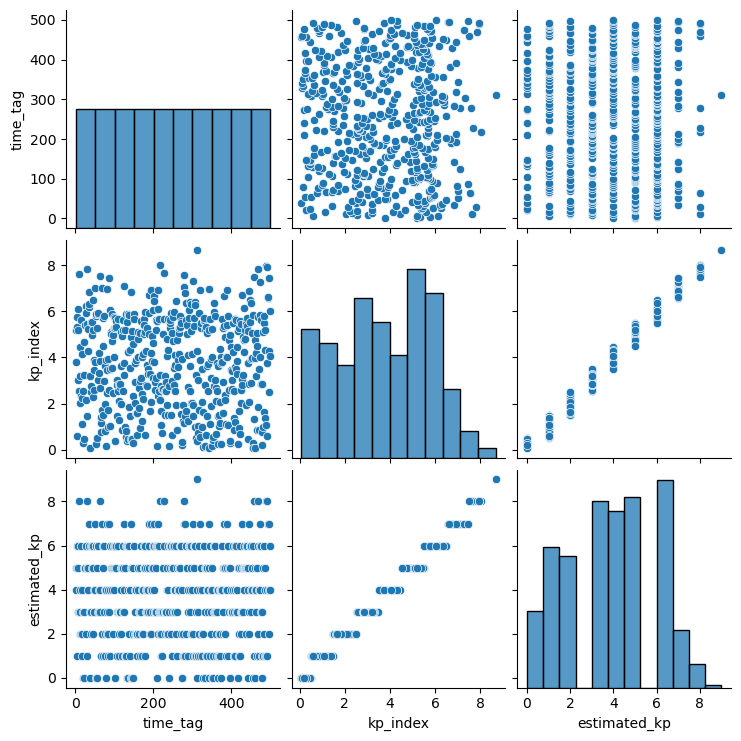

In [1]:
import seaborn as sns
import pandas as pd

data = pd.read_csv("kp_index_prediction_test500datatpoints.csv")
#data2 = pd.read_csv("dscovr_mag_1s.csv")

sns.pairplot(data)


In [2]:
data.head()

,time_tag,kp_index,estimated_kp
0,1,5.21,5
1,2,3.79,4
2,3,5.31,5
3,4,5.76,6
4,5,0.60,1


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

df = pd.read_csv('kp_index_prediction_test500datatpoints.csv')

 
df.fillna(df.mean(), inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['kp_index'] = scaler.fit_transform(df['kp_index'].values.reshape(-1,1))

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg


n_hours = 400
n_features = 1

reframed = series_to_supervised(df, n_hours, 1)

print(reframed.head())


     var1(t-400)  var2(t-400)  var3(t-400)  var1(t-399)  var2(t-399)  \
400          0.0     0.596512          5.0          0.0     0.431395   
401          0.0     0.431395          4.0          0.0     0.608140   
402          0.0     0.608140          5.0          0.0     0.660465   
403          0.0     0.660465          6.0          0.0     0.060465   
404          0.0     0.060465          1.0          0.0     0.701163   

     var3(t-399)  var1(t-398)  var2(t-398)  var3(t-398)  var1(t-397)  ...  \
400          4.0          0.0     0.608140          5.0          0.0  ...   
401          5.0          0.0     0.660465          6.0          0.0  ...   
402          6.0          0.0     0.060465          1.0          0.0  ...   
403          1.0          0.0     0.701163          6.0          0.0  ...   
404          6.0          0.0     0.595349          5.0          0.0  ...   

     var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  \
400        5.0        0.0   0.3

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

df = pd.read_csv('kp_index_prediction_test500datatpoints.csv')

df.fillna(df.mean(), inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['kp_index'] = scaler.fit_transform(df['kp_index'].values.reshape(-1,1))

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_hours = 400
n_features = 1

reframed = series_to_supervised(df, n_hours, 1)

print(reframed.head())

y = reframed['var1(t)']

X = reframed.drop('var1(t)', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
print("\n")

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(400, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=200, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

     var1(t-400)  var2(t-400)  var3(t-400)  var1(t-399)  var2(t-399)  \
400          1.0     0.596512          5.0          2.0     0.431395   
401          2.0     0.431395          4.0          3.0     0.608140   
402          3.0     0.608140          5.0          4.0     0.660465   
403          4.0     0.660465          6.0          5.0     0.060465   
404          5.0     0.060465          1.0          6.0     0.701163   

     var3(t-399)  var1(t-398)  var2(t-398)  var3(t-398)  var1(t-397)  ...  \
400          4.0          3.0     0.608140          5.0          4.0  ...   
401          5.0          4.0     0.660465          6.0          5.0  ...   
402          6.0          5.0     0.060465          1.0          6.0  ...   
403          1.0          6.0     0.701163          6.0          7.0  ...   
404          6.0          7.0     0.595349          5.0          8.0  ...   

     var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  \
400        5.0      399.0   0.3

Epoch 80/200
2/2 - 13s - loss: 362.3703 - val_loss: 355.3326 - 13s/epoch - 7s/step
Epoch 81/200
2/2 - 26s - loss: 361.5412 - val_loss: 354.5038 - 26s/epoch - 13s/step
Epoch 82/200
2/2 - 28s - loss: 360.7124 - val_loss: 353.6755 - 28s/epoch - 14s/step
Epoch 83/200
2/2 - 27s - loss: 359.8841 - val_loss: 352.8476 - 27s/epoch - 14s/step
Epoch 84/200
2/2 - 27s - loss: 359.0562 - val_loss: 352.0201 - 27s/epoch - 14s/step
Epoch 85/200
2/2 - 29s - loss: 358.2287 - val_loss: 351.1929 - 29s/epoch - 15s/step
Epoch 86/200
2/2 - 28s - loss: 357.4016 - val_loss: 350.3661 - 28s/epoch - 14s/step
Epoch 87/200
2/2 - 28s - loss: 356.5748 - val_loss: 349.5396 - 28s/epoch - 14s/step
Epoch 88/200
2/2 - 28s - loss: 355.7484 - val_loss: 348.7136 - 28s/epoch - 14s/step
Epoch 89/200
2/2 - 28s - loss: 354.9223 - val_loss: 347.8878 - 28s/epoch - 14s/step
Epoch 90/200
2/2 - 27s - loss: 354.0966 - val_loss: 347.0624 - 27s/epoch - 14s/step
Epoch 91/200
2/2 - 28s - loss: 353.2712 - val_loss: 346.2374 - 28s/epoch - 14

Epoch 177/200
2/2 - 28s - loss: 282.9942 - val_loss: 275.9726 - 28s/epoch - 14s/step
Epoch 178/200
2/2 - 29s - loss: 282.1820 - val_loss: 275.1604 - 29s/epoch - 14s/step
Epoch 179/200
2/2 - 28s - loss: 281.3698 - val_loss: 274.3483 - 28s/epoch - 14s/step
Epoch 180/200
2/2 - 29s - loss: 280.5577 - val_loss: 273.5362 - 29s/epoch - 14s/step
Epoch 181/200
2/2 - 27s - loss: 279.7457 - val_loss: 272.7243 - 27s/epoch - 14s/step
Epoch 182/200
2/2 - 28s - loss: 278.9337 - val_loss: 271.9124 - 28s/epoch - 14s/step
Epoch 183/200
2/2 - 27s - loss: 278.1218 - val_loss: 271.1005 - 27s/epoch - 14s/step
Epoch 184/200
2/2 - 28s - loss: 277.3099 - val_loss: 270.2887 - 28s/epoch - 14s/step
Epoch 185/200
2/2 - 29s - loss: 276.4982 - val_loss: 269.4770 - 29s/epoch - 14s/step
Epoch 186/200
2/2 - 28s - loss: 275.6865 - val_loss: 268.6654 - 28s/epoch - 14s/step
Epoch 187/200
2/2 - 28s - loss: 274.8748 - val_loss: 267.8538 - 28s/epoch - 14s/step
Epoch 188/200
2/2 - 28s - loss: 274.0633 - val_loss: 267.0423 - 2

In [ ]:
import sklearn.metrics
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import concatenate

yhat = model.predict(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)))

inv_yhat = concatenate((yhat, X_test.values[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test.values[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

def mean_absolute_error(inv_y, inv_yhat):
    return np.mean(np.abs(inv_y - inv_yhat ))
mae = mean_absolute_error(inv_y,inv_yhat )
print(f"Mean Absolute Error: {mae}")





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("planetary_k_index_1m.csv")

new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

new_yhat = model.predict(new_data)

inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2+0.162, label='mean')
plt.legend()
plt.show()

plt.plot(inv_new_yhat-new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(((inv_new_yhat+new_yhat)/2)+0.162, label='mean')
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("fabric _true.csv")

new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

new_yhat = model.predict(new_data)

inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2, label='mean')
plt.legend()
plt.show()

plt.plot(-new_yhat+3, label='predicted non inv')
plt.plot(new_yhat, label='og non inv')
plt.plot(-1/inv_new_yhat-3, label='predicted inv')
plt.plot(inv_new_yhat, label='og inv')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(-1/((inv_new_yhat+new_yhat)/2), label='mean')
plt.legend()
plt.show()





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("kp_index_prediction_test.csv")

new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

new_yhat = model.predict(new_data)

inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2+0.162, label='mean')
plt.legend()
plt.show()

plt.plot(inv_new_yhat-new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(((inv_new_yhat+new_yhat)/2)+0.162, label='mean')
plt.legend()
plt.show()